In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Constants
NSHARDS = 10
MODELS = ['MLP', 'GCN', 'HGCN']

In [10]:
def df_gen(RESULTS_DIR, NSHARDS):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [62]:
def plot_gen(df, METRIC):
	plt.scatter(df["MLP__" + METRIC], df["GCN__" + METRIC], s=5)
	plt.plot([0, 1], [0, 1], color='red', linestyle='--')
	plt.title(f'Performance comparison between GCN and MLP')
	plt.xlabel(f'{"GCN__" + METRIC}')
	plt.ylabel(f'{"MLP__" + METRIC}')
	plt.legend(fontsize='small')
	plt.tight_layout()
	plt.show()
	
	cluster_sizes = df['num_clusters'].unique()
	fig, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		MLP_better = df_2_clusters["MLP__" + METRIC] > df_2_clusters["GCN__" + METRIC]+.05
		GCN_better = df_2_clusters["GCN__" + METRIC] > df_2_clusters["MLP__" + METRIC]+.05
		total_samples = len(MLP_better)

		ax = axes[axes_index]
		ax.scatter(df_2_clusters["GCN__" + METRIC][MLP_better],
				df_2_clusters["MLP__" + METRIC][MLP_better], color = 'orange', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][GCN_better],
				df_2_clusters["MLP__" + METRIC][GCN_better], color = 'green', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][~(MLP_better | GCN_better)],
				df_2_clusters["MLP__" + METRIC][~(MLP_better | GCN_better)], s = 5)
		ax.plot([0, 1], [0, 1], color='red', linestyle='--')
		ax.scatter([], [], label=f"MLP better: {sum(MLP_better)}", color = 'orange')
		ax.scatter([], [], label=f"GCN better: {sum(GCN_better)}", color = 'green')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"GCN__" + METRIC}')
		ax.set_ylabel(f'{"MLP__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP as number of classes increases")
	plt.tight_layout()
	plt.show()

	cluster_sizes = df['num_clusters'].unique()
	_, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		small_mask = df_2_clusters['nvertex'] < 2000
		mid_mask = (df_2_clusters['nvertex'] >= 2000) & (df_2_clusters['nvertex'] < 3000)
		large_mask = df_2_clusters['nvertex'] >= 3000
		ax = axes[axes_index]
		ax.scatter(df_2_clusters["MLP__" + METRIC][small_mask], df_2_clusters["GCN__" + METRIC][small_mask], s=10, color = 'green', label = '1000-2000')
		ax.scatter(df_2_clusters["MLP__" + METRIC][mid_mask], df_2_clusters["GCN__" + METRIC][mid_mask], s=10, color = 'orange', label = '2000-3000')    
		ax.scatter(df_2_clusters["MLP__" + METRIC][large_mask], df_2_clusters["GCN__" + METRIC][large_mask], s=10, color = 'red', label = '3000-4000')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"MLP__" + METRIC}')
		ax.set_ylabel(f'{"GCN__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP based on graph size, stratified across number of classes")
	plt.tight_layout()
	plt.show()


	models = ['MLP', 'GCN', 'HGCN']

	plt.figure(figsize=(10, 6))

	for model in models:
		grouped = df.groupby('num_clusters')[f'{model}__test_accuracy']
		means = grouped.mean()
		stds = grouped.std()

		plt.errorbar(
			means.index, means.values, yerr=stds.values, fmt='o-', capsize=5, label=model
		)

	# Add random guessing baseline
	cluster_sizes = sorted(df['num_clusters'].unique())
	random_guess = [1 / c for c in cluster_sizes]
	plt.plot(cluster_sizes, random_guess, 'k--', label='Random Guessing')

	plt.xlabel('Number of Clusters')
	plt.ylabel('Accuracy')
	plt.title('Model Accuracy vs. Number of Clusters (mean ± std)')
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()

In [ ]:
RESULTS_DIR_random_gs = '../../graph_gen/snellius_gen/random_gs/random_gs'
results_df_random_gs = df_gen(RESULTS_DIR_random_gs, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [52]:
smaller_graphs_df = df_gen("../../graph_gen/snellius_gen/smaller_graphs/smaller_graphs/", NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


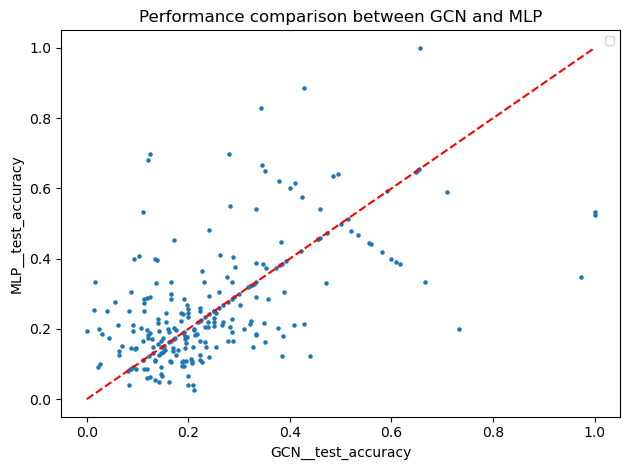

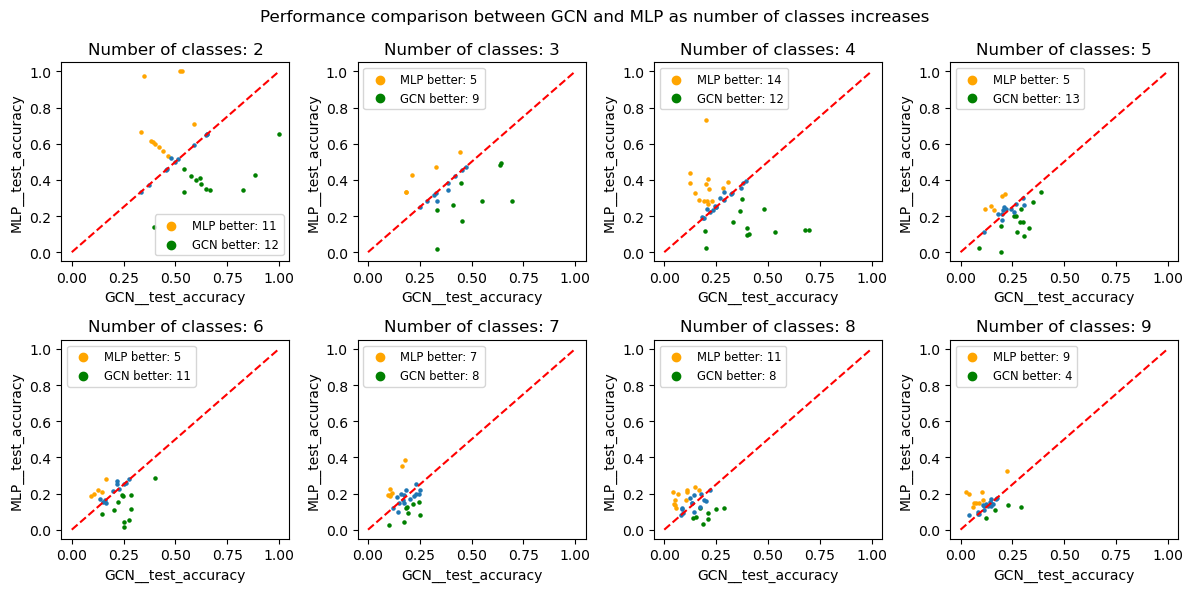

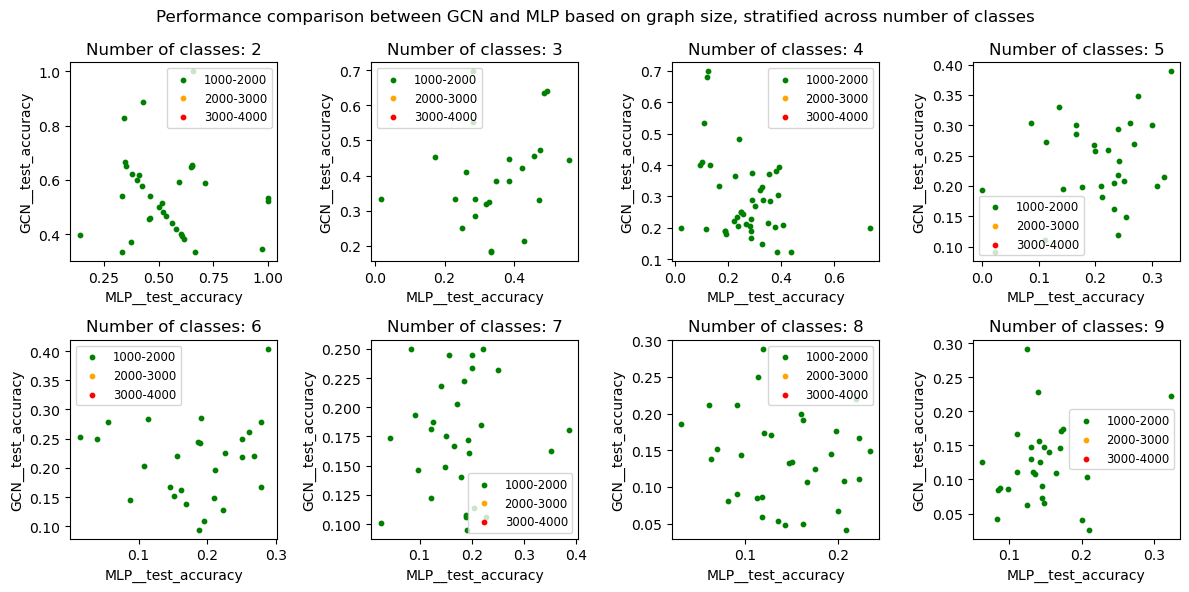

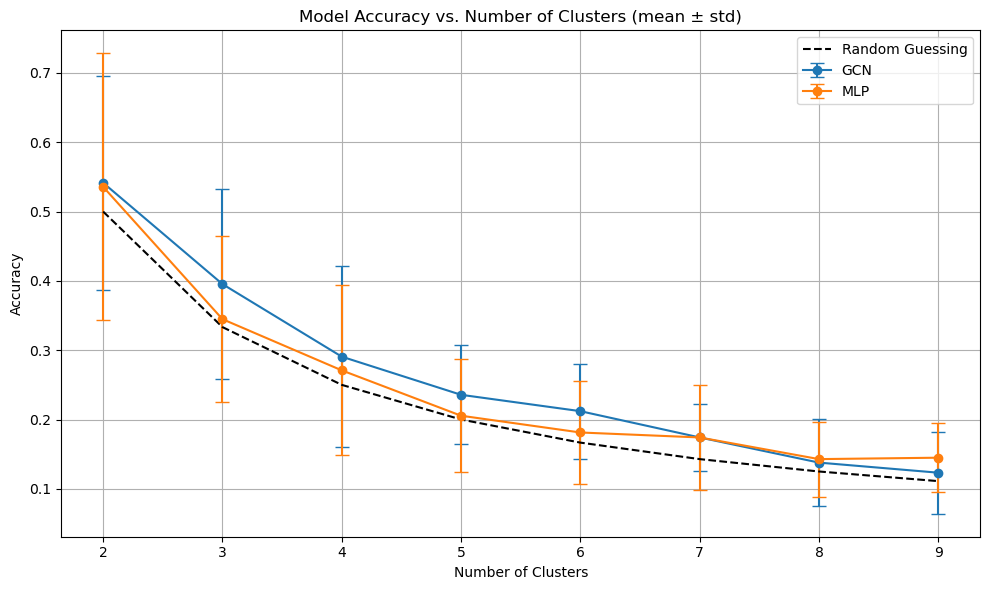

In [63]:
plot_gen(smaller_graphs_df, "test_accuracy")

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


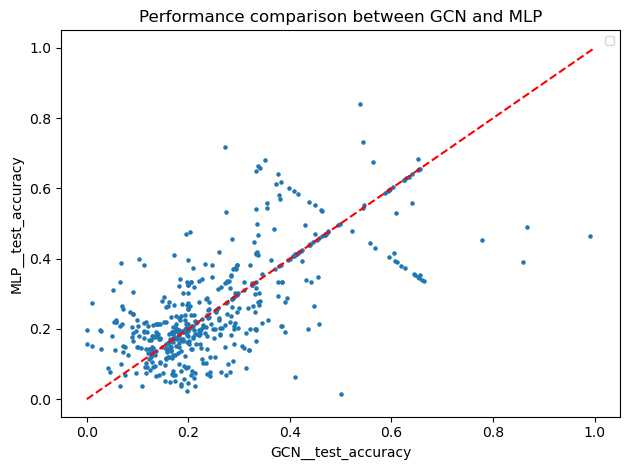

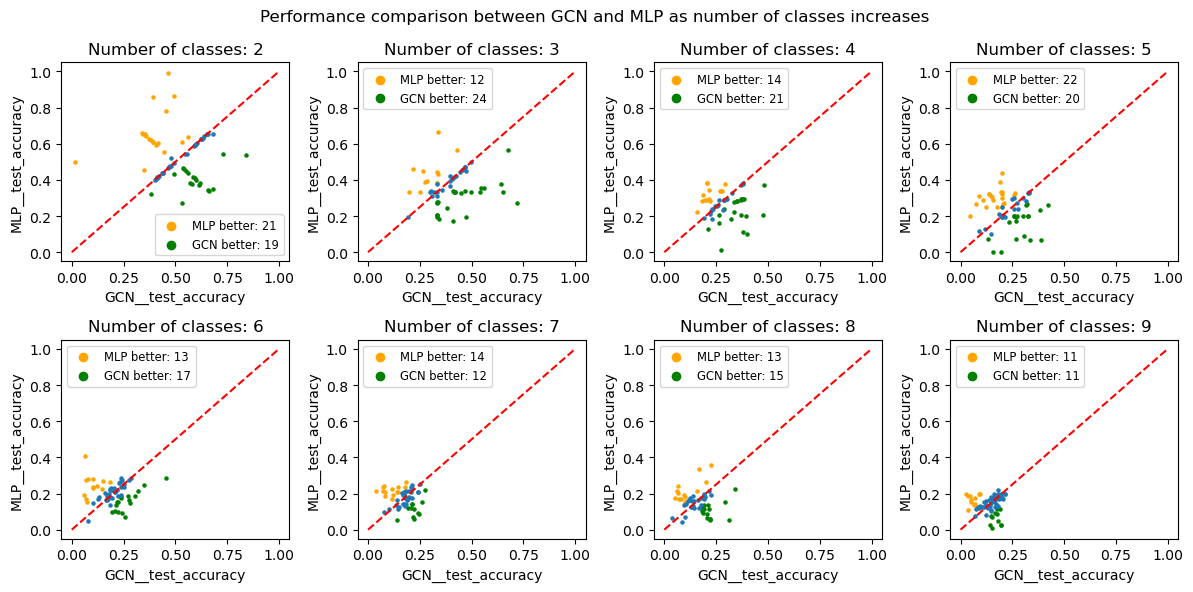

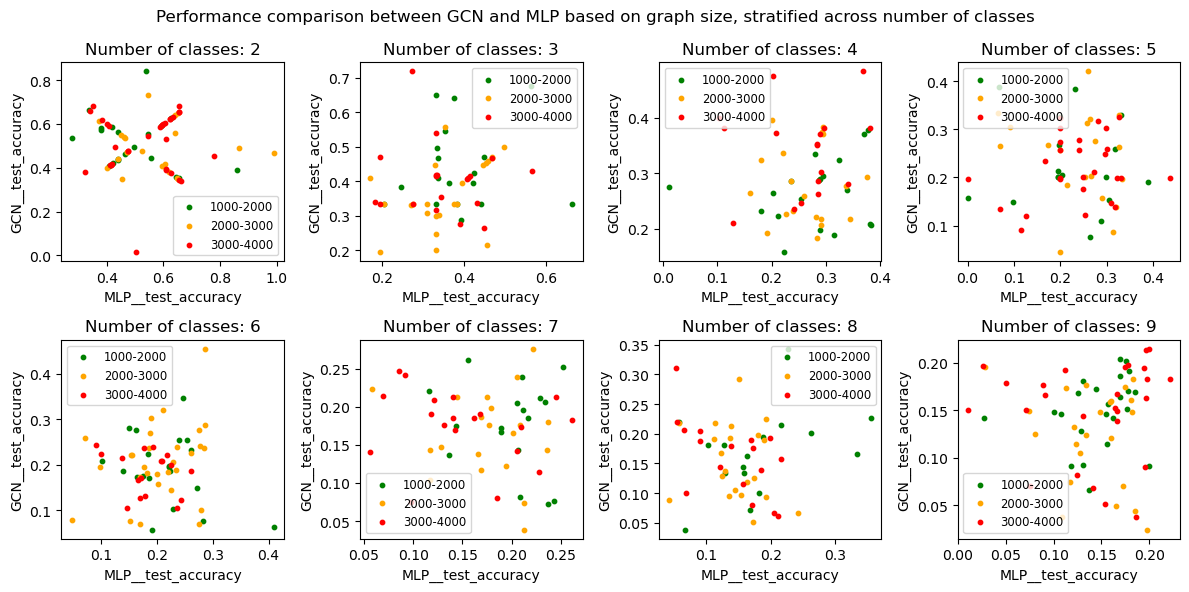

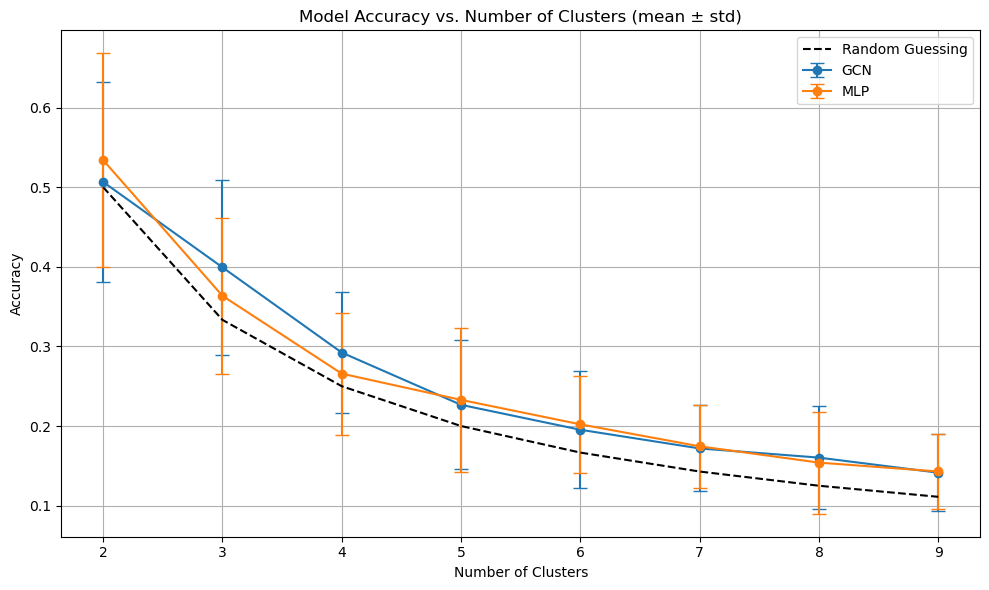

In [65]:
main_snellius_gen_link = "../../graph_gen/snellius_gen/nodeclassification/sbm/"
main_snellius_df = df_gen(main_snellius_gen_link, NSHARDS)
plot_gen(main_snellius_df, "test_accuracy")

In [11]:
RESULTS_DIR_three_mods = '../../graph_gen/local_gen/label_efficiency/5_train_per_class/'
three_mods_df = df_gen(RESULTS_DIR= RESULTS_DIR_three_mods, NSHARDS = NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [28]:
RESULTS_DIR = '../../graph_gen/local_gen/label_efficiency/varied/'
vary_train_len_df = df_gen(RESULTS_DIR= RESULTS_DIR, NSHARDS = NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [29]:
vary_train_len_df.iloc[0,20:40]

coreness_geq_10                           0.0
coreness_gini                        0.274743
avg_cc                               0.038293
transitivity                         0.039117
num_triangles                           354.0
cc_size                              0.988935
power_law_estimate                   1.898658
edge_homogeneity                      0.50673
avg_in_feature_angular_distance      0.717532
avg_out_feature_angular_distance     0.529008
feature_angular_snr                  1.356373
pareto_exponent                      0.649335
avg_degree_est                        5.10303
community_size_simpsons              0.126134
p_to_q_ratio_est                    14.234241
p_to_q_ratio__est_dc                14.070394
num_train_per_class                         4
skipped                                 False
sample_id                                   0
GCN__test_accuracy                   0.662996
Name: 0, dtype: object